## Time Correlation between Samples

In the previous notebook, an approach to extract ML and MAP estimations for the parameters of the converter. 
However, in the definition of the loss function we assumed that the residuals $r_i(z)$: 

$$
r_i(z) \;\sim\; \mathcal{N}(0, \sigma_x^2 I).
$$

And the likelihood is:

$$
p(\mathcal{D} \mid z)
= \prod_{i=0}^{N-1} \frac{1}{(2\pi\sigma_x^2)^{m/2}}
\exp\!\left(-\frac{1}{2\sigma_x^2} \| r_i(z) \|^2\right),
$$

then taking the log: 
$$
\log p(\mathcal{D} \mid z)
= -\frac{1}{2\sigma_x^2} \sum_{i=0}^{N-1} \| r_i(z) \|^2 + \text{const}.
$$
However, this is only true if the residuals are independent and we know that are data samples $x_i$ are successive samples in the time-series of the measured $i$ and $v$. So how can we handle the presence of correlation in our datapoints?

If temporal correlation is present and ignored, the main effect is:

> **Overconfident parameter estimates** — because the likelihood acts as if we have more independent information than we actually do. It follows that credible intervals and posterior variances are too narrow.

However, if since we build our MAP estimate by factoring the prior term and the likelihood term, overconfident predictions will strengthen the likelihood with respect to the prior. Therefore, the MAP estimate itself can shift.

This is a typical problem encountered in **time-series analysis** and **econometrics**.




## Correlated Residuals and Solutions
### Full Covariance Matrix Approach

The most principled way is to model the *full* residual covariance matrix:

$$
\Sigma_r^{(\mathrm{full})} \in \mathbb{R}^{(NT) \times (NT)},
$$

where $N$ is the number of time steps per transient and $m=2$ the number of measured quantities.

For each lag $k$, the covariance block

$$
\Gamma_k = \mathbb{E}[\,r_t\, r_{t-k}^\top\,]
$$

fills the $k$-th block off the diagonal of $\Sigma_r^{(\mathrm{full})}$.
The result is a **block Toeplitz** matrix with $m\times m$ blocks.

In this full-GLS model, the negative log-likelihood is

$$
\mathrm{NLL}(z) =
\frac{1}{2}R(z)^\top \Sigma_r^{(\mathrm{full})\,-1} R(z)
+ \frac{1}{2} \log\big|\Sigma_r^{(\mathrm{full})}\big|.
$$

This is exact — but expensive:

* $\Sigma_r^{(\mathrm{full})}$ is huge ($O(N^2)$ storage),
* Inversion is $O(N^3)$ unless structure is exploited.

Therefore, we look for an **simpler, approximate solution**.



### Variance Inflation Factor (VIF) Approximation

A cheaper alternative is to keep using the **per-step covariance** $\Sigma_r$ in the quadratic form, but rescale the **likelihood contribution** by a factor that accounts for the reduced *effective sample size*.

The idea: temporal correlation inflates the variance of the **sum of quadratic residual terms**, and this can be quantified by a **variance inflation factor** (VIF).

The derivation of the VIF is well known for the scalar autocorrelation function (ACF) case. Let's start by exploring that and then we can extend the results to the multivariate case. 

Here’s a rewritten version that integrates the **missing intermediate steps** and introduces **Isserlis’ theorem** before using it. I kept it consistent with the tone of your other notes:

---

### VIF Scalar Derivation

Let $\{e_t\}_{t=1}^N$ be **zero-mean scalar residuals** with variance $\sigma^2$ and autocorrelation $\rho_k=\mathrm{Corr}(e_t,e_{t-k})$.

Define **standardized residuals** $y_t=e_t/\sigma$ so that $$
\begin{align*}
\mathbb{E}[y_t^2]&=1 \\
\mathrm{Var}(y_t)&=1
\end{align*}

We consider the (scaled) sum of squared errors (SSE):

$$
S = \sum_{t=1}^N y_t^2 .
$$

Clearly, $\mathbb{E}[S]=N$. 

Its **variance** is
$$
\mathrm{Var}(S)
= \sum_{t=1}^N \mathrm{Var}(y_t^2)
+ 2\sum_{k=1}^{N-1}\sum_{t=k+1}^N \mathrm{Cov}(y_t^2,y_{t-k}^2).
$$


#### Recall Isserlis’ theorem

For zero-mean jointly **Gaussian variables** $x_1,\dots,x_4$,

$$
\mathbb{E}[x_1x_2x_3x_4] =
\mathbb{E}[x_1x_2]\mathbb{E}[x_3x_4] +
\mathbb{E}[x_1x_3]\mathbb{E}[x_2x_4] +
\mathbb{E}[x_1x_4]\mathbb{E}[x_2x_3].
$$

This allows us to reduce fourth-order moments to products of second-order ones.


#### Step 2. Per-time variance term

Take $x_1=x_2=x_3=x_4=y_t$:

$$
\mathbb{E}[y_t^4] = 3\mathbb{E}[y_t^2]^2 = 3.
$$

So

$$
\mathrm{Var}(y_t^2) = \mathbb{E}[y_t^4] - \mathbb{E}[y_t^2]^2 = 3 - 1 = 2.
$$

Summing over $t$ gives the baseline term $2N$.

Note that if we skip the whitening and $\mathrm{Var}(y_t)=\sigma_y^2$ instead of $1$, then $\mathrm{Var}(y_t^2)=2\sigma_y^4$.


#### Step 3. Lagged covariance term

For lag $k$, apply Isserlis with $x_1=x_2=y_t$, $x_3=x_4=y_{t-k}$:

$$
\mathbb{E}[y_t^2 y_{t-k}^2] =
\mathbb{E}[y_t^2]\mathbb{E}[y_{t-k}^2] + 2\mathbb{E}[y_t y_{t-k}]^2
= 1\cdot 1 + 2\rho_k^2.
$$

Thus

$$
\mathrm{Cov}(y_t^2,y_{t-k}^2) =
(1+2\rho_k^2) - 1 = 2\rho_k^2.
$$

There are $(N-k)$ such pairs at lag $k$, so

$$
2\sum_{t=k+1}^N \mathrm{Cov}(y_t^2,y_{t-k}^2) = 4(N-k)\rho_k^2.
$$


#### Step 4. Combine terms

$$
\mathrm{Var}(S)
= 2N \;+\; 4\sum_{k=1}^{N-1}(N-k)\rho_k^2.
$$

For large $N$, $(N-k)/N \approx 1$, giving

$$
\mathrm{Var}(S) \;\approx\; 2N\left(1 + 2\sum_{k\ge1}\rho_k^2\right).
$$

Relative to the i.i.d. case ($2N$), the **variance inflation factor** is

$$
\boxed{\mathrm{VIF}_{\text{scalar}} \;=\; 1 + 2\sum_{k=1}^{K}\rho_k^2 }.
$$

This means that 
$$
\mathrm{Var}(S) \;\approx\; 2N \cdot \mathrm{VIF}.
$$

Where for uncorrelated i.i.d. whitened residuals, we would get: 
$$
\mathrm{Var}(S) \;=\; 2N 
$$

So, $\mathrm{VIF} = 1$


#### Step 4b. Approximation tradeoff - Bias vs Variance

The simplification

$$
\mathrm{Var}(S) \;\approx\; 2N\left(1 + 2\sum_{k\ge1}\rho_k^2\right),
$$

comes from replacing the exact weights $(N-k)/N$ with $1$.

* **Exact form:** unbiased but higher variance when estimated from finite samples, since $(N-k)/N$ shrinks with $k$ and introduces more noise at long lags.
* **Approximate form:** slightly biased (it effectively overweights longer lags), but more stable and easier to interpret, especially as $N\to\infty$.

In practice, this bias–variance tradeoff is considered acceptable: a modest bias in the variance inflation factor leads to more robust estimates of the effective sample size. For this reason, applied econometrics often uses **lag tapers** (e.g. Bartlett weights in the Newey–West estimator), which deliberately *downweight higher lags* to reduce estimation noise while controlling bias.

#### Step 5. Interpretation

* **Variance inflation (raw sum).**  
  With standardized residuals, the correlated-case variance of the **raw sum**
  $
  S=\sum_{t=1}^N y_t^2
  $
  is
  $
  \mathrm{Var}(S) \;=\; 2N \cdot \mathrm{VIF}, 
  \qquad \text{where}\quad \mathrm{VIF}=1+2\sum_{k\ge1}\rho_k^2.
  $
  This is **larger** than the i.i.d. baseline $2N$.

* **Effective sample size is defined for a normalized statistic.**  
  For the **per‑step average**
  $
  \bar S \;=\; \frac{1}{N}\sum_{t=1}^N y_t^2,
  $
  we have
  $
  \mathrm{Var}(\bar S) \;=\; \frac{2}{N}\cdot \mathrm{VIF}.
  $
  If we want to match this to the i.i.d. variance formula $2/N_{\text{eff}}$, then
  $$
  \frac{2}{N_{\text{eff}}} \;=\; \frac{2}{N}\cdot \mathrm{VIF}
  \;\;\Rightarrow\;\;
  \boxed{\,N_{\text{eff}} \;=\; \frac{N}{\mathrm{VIF}}\, }.
  $$
  So $N_{\text{eff}}$ is the number of independent samples that would give the **same variance for the average** $\bar S$.  

* **Chi‑square “degrees‑of‑freedom” analogy**  
  If one insists on a $\chi^2_\nu$-matching for the **raw** $S$ via $\mathrm{Var}(S)=2\nu$,
  then $\nu = N\cdot \mathrm{VIF}$, which is not an “effective sample size” but merely a variance-matching device for the unnormalized sum.

* **Non‑Gaussian residuals (excess kurtosis $\kappa$).**  
  The i.i.d. baseline for the raw sum becomes $(2+\kappa)N$, hence
  $
  \mathrm{Var}(S) = (2+\kappa)N \cdot \mathrm{VIF}, 
  \qquad
  \mathrm{Var}(\bar S) = \frac{2+\kappa}{N}\cdot \mathrm{VIF}.
  $
  The same definition $N_{\text{eff}}=N/\mathrm{VIF}$ applies to the **average** statistic.

Now let's **extend the previous derivation to our multivariate case.**

### VIF Multivariate Derivation

Let $\{r_t\}_{t=1}^N$ be **zero-mean vector residuals** with $r_t\in\mathbb{R}^m$ and per-step covariance $\Sigma_r\succ0$.

Define **whitened residuals** $y_t=\Sigma_r^{-1/2}r_t$ so that

$$
\mathbb{E}[y_t]=0,\qquad \mathbb{E}[y_t y_t^\top]=I_m.
$$

We study the (scaled) quadratic SSE:

$$
S \;=\; \sum_{t=1}^N r_t^\top \Sigma_r^{-1} r_t
\;=\; \sum_{t=1}^N \|y_t\|^2.
$$

Clearly, $\mathbb{E}[S]=mN$, where $m$ is the dimensionality of the vectors $r_t$.

Its **variance** is

$$
\mathrm{Var}(S)
= \sum_{t=1}^N \mathrm{Var}\!\big(\|y_t\|^2\big)
+ 2\sum_{k=1}^{N-1}\sum_{t=k+1}^N \mathrm{Cov}\!\big(\|y_t\|^2,\|y_{t-k}\|^2\big).
$$

---

#### Recall Isserlis’ theorem (multivariate use)

For zero-mean jointly **Gaussian** vectors, fourth-order moments reduce to products of covariances. We will apply this entrywise to $\|y_t\|^2=\sum_{j=1}^m y_{t,j}^2$.

---

#### Step 2. Per-time variance term

Let $A_t=\|y_t\|^2=\sum_{j=1}^m y_{t,j}^2$. With $y_t\sim \mathcal{N}(0,I_m)$,

$$
\mathbb{E}[A_t]=m,\qquad \mathrm{Var}(A_t)=2m.
$$

(Each $y_{t,j}^2$ has variance $2$, cross-terms vanish by independence.)  
Summing over $t$ gives the baseline term $2mN$.

---

#### Step 3. Lagged covariance term

Define the **unitless lag-$k$ cross-correlation matrix**

$$
C_k \;=\; \mathbb{E}[\,y_t\,y_{t-k}^\top\,]\in\mathbb{R}^{m\times m}.
$$

For Gaussian $y_t$, Isserlis implies

$$
\mathrm{Cov}\!\big(\|y_t\|^2,\|y_{t-k}\|^2\big) \;=\; 2\,\|C_k\|_F^2,
$$

where $\|\cdot\|_F$ is the Frobenius norm. There are $(N-k)$ pairs at lag $k$, so

$$
2\sum_{t=k+1}^N \mathrm{Cov}\!\big(\|y_t\|^2,\|y_{t-k}\|^2\big)
\;=\; 4\,(N-k)\,\|C_k\|_F^2.
$$

---

#### Step 4. Combine terms

$$
\mathrm{Var}(S) \;=\; 2mN \;+\; 4\sum_{k=1}^{N-1}(N-k)\,\|C_k\|_F^2.
$$

For large $N$, $(N-k)/N\approx 1$, giving

$$
\mathrm{Var}(S) \;\approx\; 2mN\left(1 + \frac{2}{m}\sum_{k\ge1}\|C_k\|_F^2\right).
$$

Define the **multivariate VIF**

$$
\boxed{\;\mathrm{VIF} \;=\; 1 \;+\; \frac{2}{m}\sum_{k=1}^{K}\|C_k\|_F^2\;}
$$

so that

$$
\mathrm{Var}(S) \;\approx\; 2mN \cdot \mathrm{VIF}.
$$

When $m=1$, $C_k=\rho_k$ and this collapses to the scalar result.


#### Step 5. Interpretation

* **Variance inflation (raw sum).**

  $$
  \mathrm{Var}(S) \;=\; 2mN \cdot \mathrm{VIF}, \qquad
  \mathrm{VIF}=1+\frac{2}{m}\sum_{k\ge1}\|C_k\|_F^2.
  $$

* **Effective sample size for the normalized statistic.**  
  For the **per-step average**

  $$
  \bar S \;=\; \frac{1}{N}\sum_{t=1}^N \|y_t\|^2,
  $$

  we have

  $$
  \mathrm{Var}(\bar S) \;=\; \frac{2m}{N}\cdot \mathrm{VIF}.
  $$

  Matching to the i.i.d. variance $2m/N_{\text{eff}}$ yields

  $$
  \boxed{\,N_{\text{eff}} \;=\; \frac{N}{\mathrm{VIF}}\, }.
  $$

* **Non-Gaussian residuals (excess kurtosis).**  
  If each whitened component has excess kurtosis $\kappa$ and components are uncorrelated (spherical/elliptical), then the i.i.d. baseline for the raw sum inflates to $(2+\kappa)mN$, so

  $$
  \mathrm{Var}(S) \;=\; (2+\kappa)\,mN \cdot \mathrm{VIF}, 
  \qquad
  \mathrm{Var}(\bar S) \;=\; \frac{(2+\kappa)\,m}{N}\cdot \mathrm{VIF}.
  $$

  The VIF definition remains unchanged; only the baseline factor changes.

### 3) Applying VIF to the MAP data term

With residual‑space data term

$$
\mathcal{L}_{\mathrm{data}}(z)=\frac{1}{2}\sum_{t=1}^N r_t^\top \Sigma_r^{-1} r_t,
$$

temporal correlation implies an *effective* sample size $N_{\text{eff}}=N\mathrm{VIF}$. A simple, consistent adjustment is

$$
\boxed{\mathcal{L}_{\mathrm{data}}^{\mathrm{adj}}(z)=\frac{1}{\mathrm{VIF}}\;\mathcal{L}_{\mathrm{data}}(z)}
$$

equivalently, inflate $\Sigma\_r \mapsto \mathrm{VIF}\cdot\Sigma\_r$ inside the quadratic form.

---

### 4) Estimating VIF in practice

1. **Whiten** with a plug‑in $\widehat{\Sigma}\_r$:

   $$
   \hat{y}_t=\widehat{\Sigma}_r^{-1/2} r_t.
   $$
2. **Estimate** $C_k$ by the sample cross‑correlation

   $$
   \widehat{C}_k=\frac{1}{N-k}\sum_{t=k+1}^{N}\hat{y}_t\hat{y}_{t-k}^\top.
   $$
3. **Taper** (recommended): use Bartlett/Newey–West weights

   $$
   w_k=1-\frac{k}{K+1}\quad (k\le K),\qquad \widehat{\mathrm{VIF}}=1+\frac{2}{m}\sum_{k=1}^{K} w_k^2\,\|\widehat{C}_k\|_F^2.
   $$

   Choose bandwidth \$K\$ via a rule of thumb (e.g., $K\asymp N^{1/3}$) or from where $|\widehat{C}\_k|\_F$ becomes negligible.
4. **Multiple transients**: if sequences $i=1,\dots,S$ are independent with lengths $N\_i$ and VIFs $\mathrm{VIF}*i$, the joint sum $S*{\text{tot}}$ has

   $$
   \mathrm{VIF}_{\text{tot}}=\frac{\sum_i N_i\,\mathrm{VIF}_i}{\sum_i N_i}
   $$

   (length‑weighted average). Apply this single factor to the combined data term.

---

### 5) Notes & caveats

* If residuals are nearly i.i.d., \$\widehat{\mathrm{VIF}}\to 1\$ (no penalty).
* VIF rescales the **loss level**; it does **not** change its minimizer. 
> Use HAC/Newey–West **sandwich** estimators if you also want correlation‑robust **uncertainty** around the MAP (posterior covariance / standard errors).
* Estimation stability: shrink $\widehat{\Sigma}_r$ (e.g., Ledoit–Wolf) if $m$ is not $\ll N$ $\rightarrow$ not our case; keep $K$ modest to avoid noisy high‑lag terms.


In [3]:
from typing import Callable, Iterable
from pathlib import Path
import torch
import sys

sys.path.append(str(Path.cwd().parent))

from pinn_buck.io import LoaderH5
from pinn_buck.parameter_transformation import make_log_param, reverse_log_param
from pinn_buck.data_noise_modeling.jacobian_estimation import JacobianEstimator
from pinn_buck.data_noise_modeling.covariance_matrix_function_archive import (
    covariance_matrix_on_basic_residuals,
    generate_residual_covariance_matrix,
    chol,
)

import matplotlib
from scipy.stats import lognorm
from pinn_buck.constants import ParameterConstants, MeasurementGroupArchive
from pinn_buck.data_noise_modeling.auxiliary import rel_tolerance_to_sigma

TRUE_PARAMS = ParameterConstants.TRUE
NOMINAL = ParameterConstants.NOMINAL
REL_TOL = ParameterConstants.REL_TOL
PRIOR_SIGMA = rel_tolerance_to_sigma(
    REL_TOL, number_of_stds_in_relative_tolerance=1
)  # transforms relative tolerance to the value of the standard deviation

# print the nominal parameters
print("Nominal Parameters:")
print(NOMINAL)

print("Relative Tolerances:")
print(REL_TOL)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# %%
## Noise Power
lsb_i = 10 / (2**12 - 1)  # 10 A full-scale current
lsb_v = 30 / (2**12 - 1)  # 30 V full-scale voltage

# i and v noise levels should probably be considered separately:

sigma_noise_ADC_i = 1 * lsb_i  # 1 LSB noise
sigma_noise_5_i = 5 * lsb_i  # 5 LSB noise
sigma_noise_10_i = 10 * lsb_i  # 10 LSB noise

sigma_noise_ADC_v = 1 * lsb_v  # 1 LSB noise
sigma_noise_5_v = 5 * lsb_v  # 5 LSB noise
sigma_noise_10_v = 10 * lsb_v  # 10 LSB noise

noise_power_ADC_i = sigma_noise_ADC_i**2
noise_power_5_i = sigma_noise_5_i**2
noise_power_10_i = sigma_noise_10_i**2

noise_power_ADC_v = sigma_noise_ADC_v**2
noise_power_5_v = sigma_noise_5_v**2
noise_power_10_v = sigma_noise_10_v**2

noise_power_dict = {
    "ADC_error": (noise_power_ADC_i, noise_power_ADC_v),
    "5 noise": (noise_power_5_i, noise_power_5_v),
    "10 noise": (noise_power_10_i, noise_power_10_v),
}

Nominal Parameters:
Parameters(L=0.00068, RL=0.4, C=0.00015, RC=0.25, Rdson=0.25, Rloads=[3.3, 10.0, 6.8], Vin=46.0, VF=1.1)
Relative Tolerances:
Parameters(L=0.5, RL=0.4, C=0.5, RC=0.5, Rdson=0.5, Rloads=[0.3, 0.3, 0.3], Vin=0.3, VF=0.3)


In [6]:
from typing import Tuple
from pinn_buck.model.model_param_estimator import BaseBuckEstimator, BuckParamEstimator
from pinn_buck.model.residuals import basic_residual
from pinn_buck.model.residual_time_correlation import ResidualDiagnosticsGaussian
from pinn_buck.model.map_loss  import MAPLoss
from pinn_buck.model.loss_function_archive import loss_whitened


# load measurements
db_dir = Path(r"C:/Users/JC28LS/OneDrive - Aalborg Universitet/Desktop/Work/Databases")
h5filename = "buck_converter_Shuai_processed.h5"
io = LoaderH5(db_dir, h5filename)

model = BuckParamEstimator(param_init=ParameterConstants.NOMINAL).to(device)


covariance_matrices = []
jacobian_estimator = JacobianEstimator()

for label, data_covariance in noise_power_dict.items():
    io.load(label)
    X = torch.tensor(io.M.data, device=device)
    jac = jacobian_estimator.estimate_Jacobian(
        X, model, number_of_samples=500, dtype=torch.float64
    )[
        ..., :2, :2
    ]  # keep a size of (T, 2, 2)

    covariance_matrix = generate_residual_covariance_matrix(
        data_covariance=data_covariance,
        residual_covariance_func=covariance_matrix_on_basic_residuals,
        jac=jac,
        dtype=torch.float64,
    )

    covariance_matrices.append(covariance_matrix)


def calculate_Lr_and_vif(
    model: BaseBuckEstimator, X: torch.Tensor, data_covariance: Tuple[float, float]
) -> Tuple[torch.Tensor, torch.Tensor]:
    """Update the MAP loss function with the current model parameters."""
    jacobian_estimator = JacobianEstimator()
    jac = jacobian_estimator.estimate_Jacobian(
        X, model, number_of_samples=500, dtype=torch.float64
    )[..., :2, :2]
    covariance_matrix = generate_residual_covariance_matrix(
        data_covariance=data_covariance,
        residual_covariance_func=covariance_matrix_on_basic_residuals,
        jac=jac,
        dtype=torch.float64,
    )

    Lr = chol(covariance_matrix)

    with torch.no_grad():
        pred = model(X)
        targets = model.targets(X)
        residuals = basic_residual(pred, targets)

    gauss_residual_diagnostics = ResidualDiagnosticsGaussian(residuals=residuals)
    vif = gauss_residual_diagnostics.quadloss_vif_from_residuals()
    vif_mean = torch.mean(vif)
    return Lr, vif_mean

Lrs = {}
vifs = {}
idx = 1

for label, data_covariance in noise_power_dict.items():
    X = torch.tensor(io.M.data, device=device)
    with torch.no_grad():
        targets = model.targets(X)
        preds = model(X)
        residuals = basic_residual(preds, targets)
    # plot the residuals
    residual_diagnostic_gaussian = ResidualDiagnosticsGaussian(residuals=residuals)
    vif_perchannel = residual_diagnostic_gaussian.per_channel_vif()
    vif_perchannel = torch.median(vif_perchannel, dim=0).values

    io.load(label)
    Lr, vif = calculate_Lr_and_vif(model, X, data_covariance)
    Lrs[data_covariance] = Lr
    vifs[data_covariance] = vif

    print(f"GROUP {idx}) VIF: {vif} - per channel VIF: {vif_perchannel}")
    idx += 1

GROUP 1) VIF: 1.9733697778824 - per channel VIF: tensor([1.6082, 1.8506], dtype=torch.float64)
GROUP 2) VIF: 12.724304507962358 - per channel VIF: tensor([8.0208, 8.7813], dtype=torch.float64)
GROUP 3) VIF: 3.7353633910157953 - per channel VIF: tensor([2.2030, 3.1566], dtype=torch.float64)


In [5]:
from functools import partial
def callback_function_on_map(
    model: BaseBuckEstimator,
    map_loss: MAPLoss,
    X: torch.Tensor,
    data_covariance: Tuple[float, float],
) -> MAPLoss:
    """Update the MAP loss function with the current model parameters."""
    Lr, vif = calculate_Lr_and_vif(model, X, data_covariance)
    map_loss = map_loss.clone(
        L=Lr,  # Cholesky factor of the diagonal noise covariance matrix
        weight_likelihood_loss=1.0 / vif,  # use the VIF as the main loss
    )
    return map_loss

In [10]:
import numpy as np
from typing import Dict

from pinn_buck.model.trainer import Trainer, TrainingConfigs
from pinn_buck.laplace_posterior_fitting import LaplaceApproximator, LaplacePosterior
from pinn_buck.constants import MeasurementGroupArchive

def set_seed(seed: int = 1234):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


set_seed(123)
device = "cpu"
out_dir = Path.cwd().parent / "RESULTS" / "LIKELIHOODS" / "FWD_VIF1"
out_dir.mkdir(parents=True, exist_ok=True)

run_configs = TrainingConfigs(
    lr_adam=1e-3,
    epochs_adam=10_000,
    device="cpu",
    patience=3000,
    lr_reduction_factor_adam=0.5,
    epochs_lbfgs=100,
    lr_lbfgs=1,
    history_size_lbfgs=20,
    max_iter_lbfgs=100,
    clip_gradient_adam=1e6,
    save_every_lbfgs=1,
)


noisy_measurements = {}
trained_models = {}
trained_runs = {}
laplace_posteriors: Dict[str, LaplacePosterior] = {}

# Load the data from the hdf5 file
io = LoaderH5(db_dir, h5filename)

for idx, (group_name, data_covariance) in enumerate(noise_power_dict.items()):
    if "Sync" in group_name:
        # Skip the Sync Error group for now
        continue
    print(f"Loading group {group_name}")
    io.load(group_name)

    # Store the measurement in a dictionary
    noisy_measurements[group_name] = io.M

    print(f"\n{'-'*50}")
    print(f"{idx}) Training with {group_name} data")

    # Train the model on the noisy measurement
    X = torch.tensor(io.M.data, device=device)
    model = BuckParamEstimator(param_init=ParameterConstants.NOMINAL).to(device)

    Lr, vif0 = calculate_Lr_and_vif(model, X, data_covariance)

    map_loss = MAPLoss(
        initial_params=ParameterConstants.NOMINAL,
        initial_sigma=PRIOR_SIGMA,
        loss_likelihood_function=loss_whitened,  # loss function for the forward-backward pass
        residual_function=basic_residual,
        L = Lr
    ).likelihood


    callback_func = partial(callback_function_on_map, data_covariance=data_covariance)
    # # initially don't use vif which is too high for params far from the optimum
    # map_loss = map_loss_update_function(model, map_loss, X).clone(weight_likelihood_loss=1.0)

    trainer = Trainer(
        model=model,
        map_loss=map_loss,
        cfg=run_configs,
        device=device,
    )

    trainer.fit(
        X=X, update_loss_callback=callback_func, update_every_adam=3_000, update_every_lbfgs=30
    )

    ### fit a Laplace Approximator for the posterior
    print("Fitting Laplace Posterior")
    laplace_posterior_approx = LaplaceApproximator(
        model=trainer.optimized_model(),
        loss_fn=trainer.map_loss,
        device=device,
        damping=1e-7,
    )
    laplace_posterior = laplace_posterior_approx.fit(X)
    laplace_posterior.save(out_dir / f"laplace_posterior_{group_name}.json")

    laplace_posteriors[group_name] = laplace_posterior
    trained_models[group_name] = trainer.optimized_model()
    trained_runs[group_name] = trainer.history

    trainer.history.get_best_parameters().save(out_dir / f"best_params_{group_name}.json")
    trainer.history.save_to_csv(out_dir / f"history_{group_name}.csv")

    print("Final VIF:", 1 / trainer.map_loss.weight_likelihood_loss)
    print("\n \n \n")

Loading group ADC_error

--------------------------------------------------
0) Training with ADC_error data
[Adam] Iteration 0, gradient_norm  nan, loss 1.289212e+05,
Parameters: L=6.800e-04, RL=4.000e-01, C=1.500e-04,  RC=2.500e-01, Rdson=2.500e-01,  Rloads=[3.300e+00, 1.000e+01, 6.800e+00],  Vin=46.000, VF=1.100e+00
[Adam] Iteration 1000, gradient_norm 1.191188e+03, loss 9.153469e+01,
Parameters: L=7.294e-04, RL=3.360e-01, C=1.644e-04,  RC=2.008e-01, Rdson=2.040e-01,  Rloads=[3.100e+00, 1.019e+01, 6.098e+00],  Vin=48.157, VF=1.053e+00
[Adam] Iteration 2000, gradient_norm 2.790941e+02, loss 6.586923e+01,
Parameters: L=7.279e-04, RL=3.235e-01, C=1.645e-04,  RC=2.008e-01, Rdson=2.117e-01,  Rloads=[3.100e+00, 1.020e+01, 6.099e+00],  Vin=48.088, VF=1.055e+00
[Adam] vif 1.5040184061708353 at iteration 3000
[Adam] Iteration 3000, gradient_norm 5.314571e+01, loss 3.964644e+01,
Parameters: L=7.270e-04, RL=3.166e-01, C=1.645e-04,  RC=2.008e-01, Rdson=2.195e-01,  Rloads=[3.100e+00, 1.020e+01, 6

c:\Users\JC28LS\OneDrive - Aalborg Universitet\Desktop\Work\buck_converter_estimator\pinn_buck\laplace_posterior_plotting.py:913: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


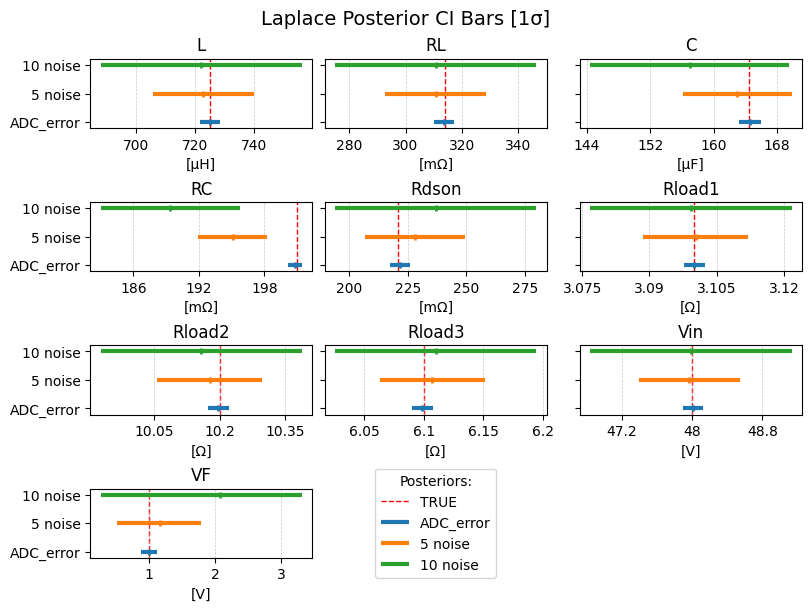

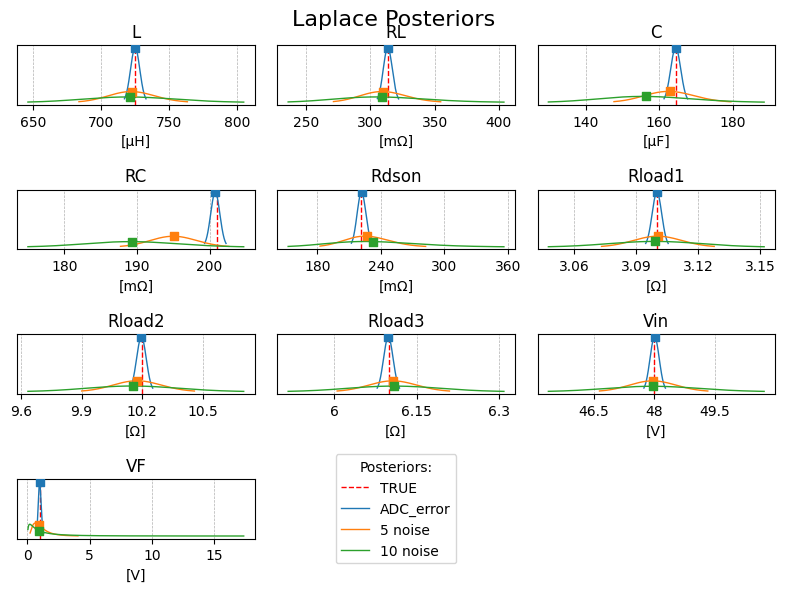

In [13]:
from pinn_buck.laplace_posterior_plotting import LaplacePosteriorPlotter

out_directory = Path.cwd().parent / "RESULTS" / "LIKELIHOODS"
save_dir = out_directory / "FWD_VIF1"

lplotter = LaplacePosteriorPlotter.from_dir(save_dir)

lplotter.plot_ci(n_sigma=1, ncols=3, true_params=TRUE_PARAMS, figsize=(8, 6));
lplotter.plot_laplace_posteriors(true_params=TRUE_PARAMS, ncols=3, figsize=(8, 6));
# lplotter.plot_uncertainty_percent(figsize=(4, 4))

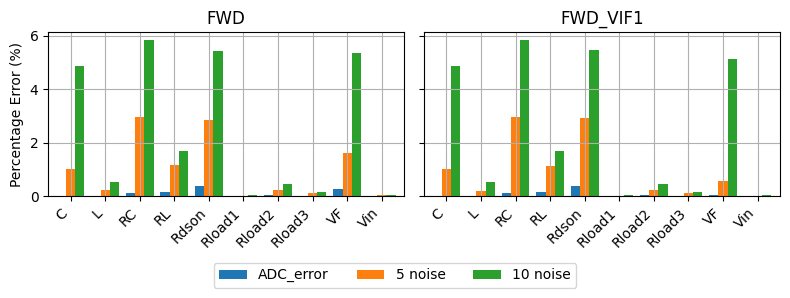

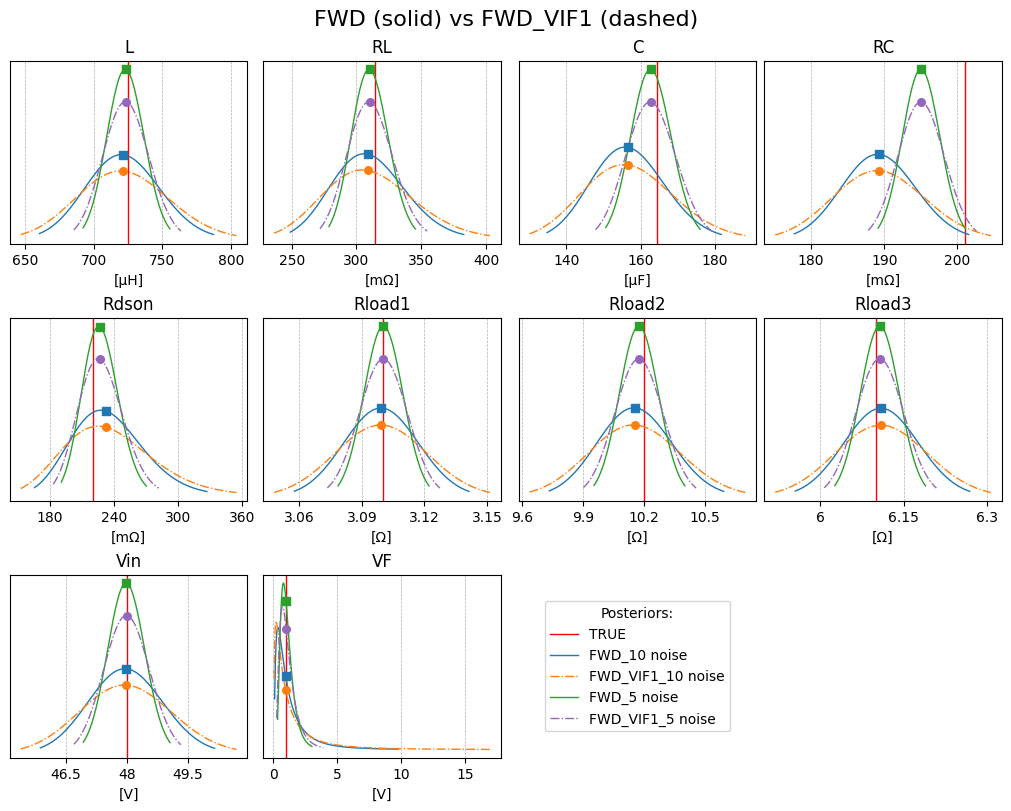

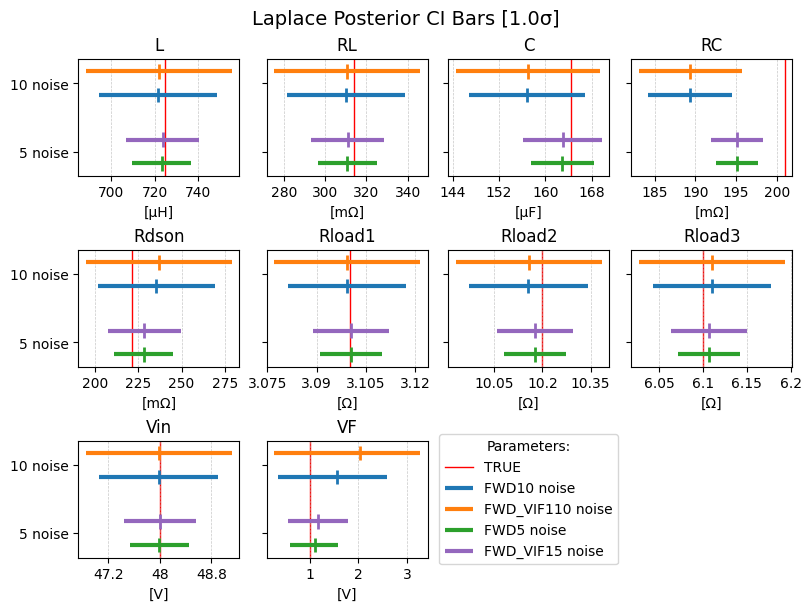

In [17]:
from pinn_buck.model_results.history import TrainingHistory
from pinn_buck.model_results.ploting_comparisons import ResultsComparerTwo
from pinn_buck.laplace_posterior_plotting_comparison import LaplaceResultsComparer


out_directory = Path.cwd().parent / "RESULTS" / "LIKELIHOODS"
directory_dictionary = {"FWD": out_directory / "FWD", "FWD_VIF1": out_directory / "FWD_VIF"}
rc = ResultsComparerTwo.from_dirs(directory_dictionary)
# Choose the labels you care about (ints map via the default dict; strings work too)
labels = ("ADC_error", "5 noise", "10 noise")

# Final % error comparison (side-by-side)
fig, ax = rc.plot_comparison(
    labels=labels, target=TRUE_PARAMS, select_lowest_loss=True, legend_bottom_inch=0.1
)

# Optional: tracked parameters for specific curves
# fig, axes = rc.plot_tracked(target=TRUE_PARAMS, labels=labels, figsize=(10, 8))

laplace_comparer = LaplaceResultsComparer.from_dirs(directory_dictionary)
laplace_comparer.plot_posteriors_grid(
    skip_labels=("ADC_error",),
    ncols=4,
    # prior_mu=NOMINAL,
    # prior_sigma=PRIOR_SIGMA,
    true_params=TRUE_PARAMS,
)
laplace_comparer.plot_ci(
    skip_labels=("ADC_error",),
    ncols=4,
    true_params=TRUE_PARAMS,
    figsize=(8, 6),
);

## MAP optimization

Now we also consider the priors, since the VIF only affects the likelihood term, we expect some shift in the MAP estimate with respect to the MLE. 

In [18]:
import numpy as np
from typing import Dict

from pinn_buck.model.trainer import Trainer, TrainingConfigs
from pinn_buck.laplace_posterior_fitting import LaplaceApproximator, LaplacePosterior
from pinn_buck.constants import MeasurementGroupArchive


def set_seed(seed: int = 1234):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


set_seed(123)
device = "cpu"
out_dir = Path.cwd().parent / "RESULTS" / "MAP" / "FWD_VIF"
out_dir.mkdir(parents=True, exist_ok=True)

run_configs = TrainingConfigs(
    lr_adam=1e-3,
    epochs_adam=10_000,
    device="cpu",
    patience=3000,
    lr_reduction_factor_adam=0.5,
    epochs_lbfgs=100,
    lr_lbfgs=1,
    history_size_lbfgs=20,
    max_iter_lbfgs=100,
    clip_gradient_adam=1e6,
    save_every_lbfgs=1,
)


noisy_measurements = {}
trained_models = {}
trained_runs = {}
laplace_posteriors: Dict[str, LaplacePosterior] = {}

# Load the data from the hdf5 file
io = LoaderH5(db_dir, h5filename)

for idx, (group_name, data_covariance) in enumerate(noise_power_dict.items()):
    if "Sync" in group_name:
        # Skip the Sync Error group for now
        continue
    print(f"Loading group {group_name}")
    io.load(group_name)

    # Store the measurement in a dictionary
    noisy_measurements[group_name] = io.M

    print(f"\n{'-'*50}")
    print(f"{idx}) Training with {group_name} data")

    # Train the model on the noisy measurement
    X = torch.tensor(io.M.data, device=device)
    model = BuckParamEstimator(param_init=ParameterConstants.NOMINAL).to(device)

    Lr, vif0 = calculate_Lr_and_vif(model, X, data_covariance)

    map_loss = MAPLoss(
        initial_params=ParameterConstants.NOMINAL,
        initial_sigma=PRIOR_SIGMA,
        loss_likelihood_function=loss_whitened,  # loss function for the forward-backward pass
        residual_function=basic_residual,
        L=Lr,
    )
    
    callback_func = partial(callback_function_on_map, data_covariance=data_covariance)
    # # initially don't use vif which is too high for params far from the optimum
    # map_loss = map_loss_update_function(model, map_loss, X).clone(weight_likelihood_loss=1.0)

    trainer = Trainer(
        model=model,
        map_loss=map_loss,
        cfg=run_configs,
        device=device,
    )

    trainer.fit(
        X=X, update_loss_callback=callback_func, update_every_adam=3_000, update_every_lbfgs=30
    )

    ### fit a Laplace Approximator for the posterior
    print("Fitting Laplace Posterior")
    laplace_posterior_approx = LaplaceApproximator(
        model=trainer.optimized_model(),
        loss_fn=trainer.map_loss,
        device=device,
        damping=1e-7,
    )
    laplace_posterior = laplace_posterior_approx.fit(X)
    laplace_posterior.save(out_dir / f"laplace_posterior_{group_name}.json")

    laplace_posteriors[group_name] = laplace_posterior
    trained_models[group_name] = trainer.optimized_model()
    trained_runs[group_name] = trainer.history

    trainer.history.get_best_parameters().save(out_dir / f"best_params_{group_name}.json")
    trainer.history.save_to_csv(out_dir / f"history_{group_name}.csv")

    print("Final VIF:", 1 / trainer.map_loss.weight_likelihood_loss)
    print("\n \n \n")

Loading group ADC_error

--------------------------------------------------
0) Training with ADC_error data
[Adam] Iteration 0, gradient_norm  nan, loss 1.289212e+05,
Parameters: L=6.800e-04, RL=4.000e-01, C=1.500e-04,  RC=2.500e-01, Rdson=2.500e-01,  Rloads=[3.300e+00, 1.000e+01, 6.800e+00],  Vin=46.000, VF=1.100e+00
[Adam] Iteration 1000, gradient_norm 1.189306e+03, loss 9.214227e+01,
Parameters: L=7.294e-04, RL=3.360e-01, C=1.644e-04,  RC=2.008e-01, Rdson=2.040e-01,  Rloads=[3.100e+00, 1.019e+01, 6.098e+00],  Vin=48.157, VF=1.053e+00
[Adam] Iteration 2000, gradient_norm 2.779839e+02, loss 6.647601e+01,
Parameters: L=7.279e-04, RL=3.235e-01, C=1.645e-04,  RC=2.008e-01, Rdson=2.117e-01,  Rloads=[3.100e+00, 1.020e+01, 6.099e+00],  Vin=48.089, VF=1.056e+00
[Adam] vif 1.5038662770195756 at iteration 3000
[Adam] Iteration 3000, gradient_norm 5.391227e+01, loss 4.027685e+01,
Parameters: L=7.270e-04, RL=3.166e-01, C=1.645e-04,  RC=2.008e-01, Rdson=2.196e-01,  Rloads=[3.100e+00, 1.020e+01, 6

c:\Users\JC28LS\OneDrive - Aalborg Universitet\Desktop\Work\buck_converter_estimator\pinn_buck\laplace_posterior_plotting.py:913: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


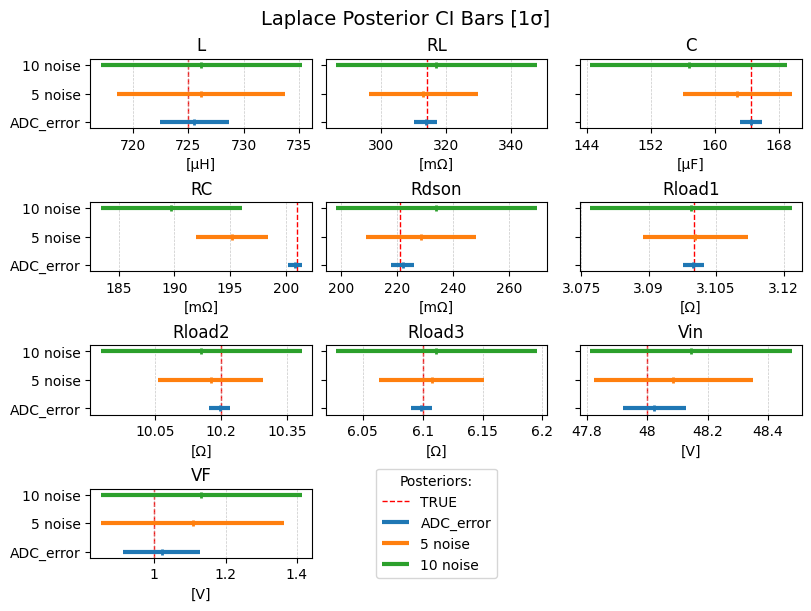

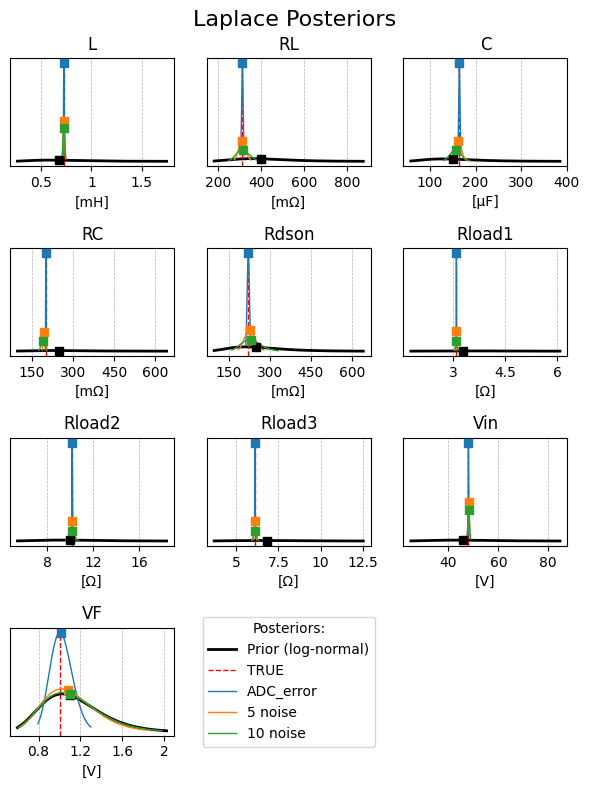

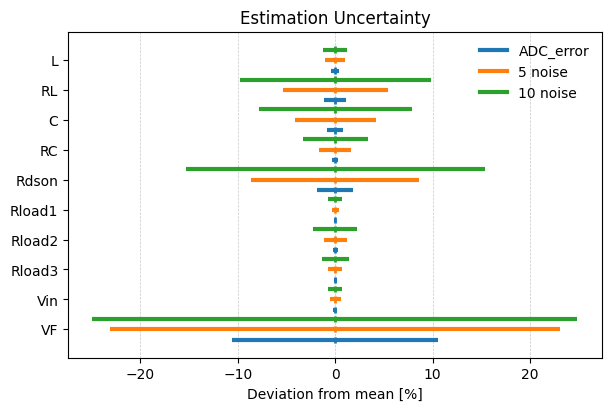

In [21]:
out_directory = Path.cwd().parent / "RESULTS" / "MAP"
save_dir = out_directory / "FWD_VIF"

lplotter = LaplacePosteriorPlotter.from_dir(save_dir)

lplotter.plot_ci(n_sigma=1, ncols=3, true_params=TRUE_PARAMS, figsize=(8, 6))
lplotter.plot_laplace_posteriors(
    true_params=TRUE_PARAMS,
    ncols=3,
    figsize=(6, 8),
    prior_mu=ParameterConstants.NOMINAL,
    prior_sigma=PRIOR_SIGMA,
)
lplotter.plot_uncertainty_percent(figsize=(6, 4));

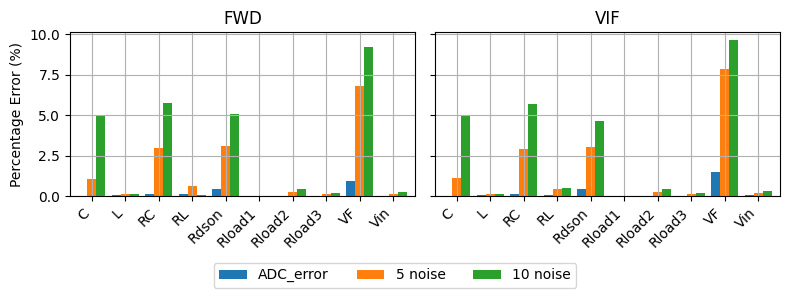

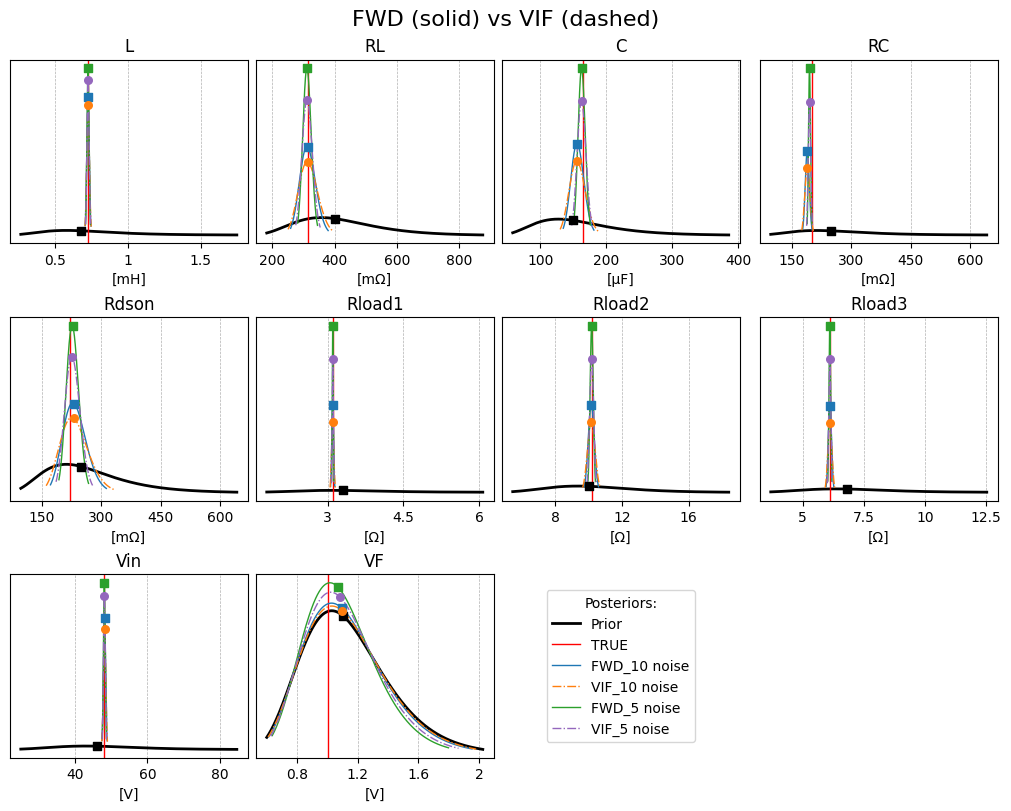

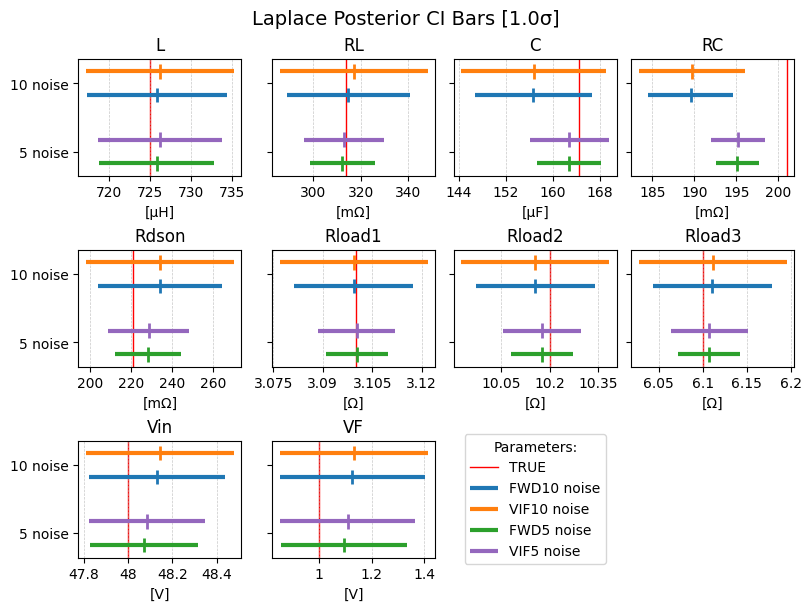

In [24]:
out_directory = Path.cwd().parent / "RESULTS"


directory_dict = {
    "FWD": out_directory / "MAP" / "FWD_no_hooks",
    "VIF": out_directory / "MAP" / "FWD_VIF",
}

rc = ResultsComparerTwo.from_dirs(directory_dict)

# Choose the labels you care about (ints map via the default dict; strings work too)
labels = ("ADC_error", "5 noise", "10 noise")

# Final % error comparison (side-by-side)
fig, ax = rc.plot_comparison(
    labels=labels, target=TRUE_PARAMS, select_lowest_loss=True, legend_bottom_inch=0.1
)

# Optional: tracked parameters for specific curves


# fig, axes = rc.plot_tracked(target=TRUE_PARAMS, labels=labels);

laplace_comparer = LaplaceResultsComparer.from_dirs(directory_dict)
laplace_comparer.plot_posteriors_grid(
    skip_labels=("ADC_error",),
    ncols=4,
    prior_mu=NOMINAL,
    prior_sigma=PRIOR_SIGMA,
    true_params=TRUE_PARAMS,
)
laplace_comparer.plot_ci(
    skip_labels=("ADC_error",),
    ncols=4,
    true_params=TRUE_PARAMS,
    figsize=(8, 6),
);

## Residual Correlation Analysis

Loading group 1: ADC_error

--------------------------------------------------
The VIF values are:7.73 15.58 14.87 

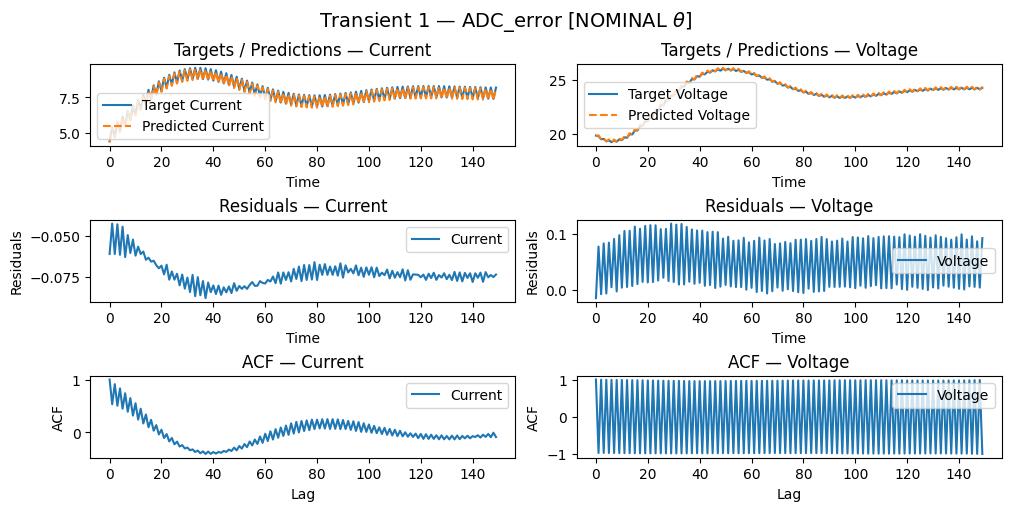

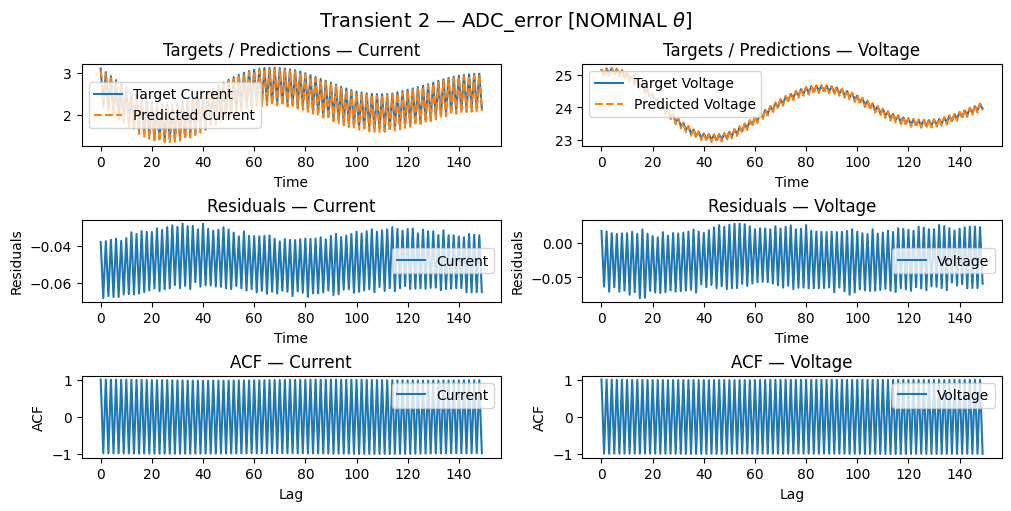

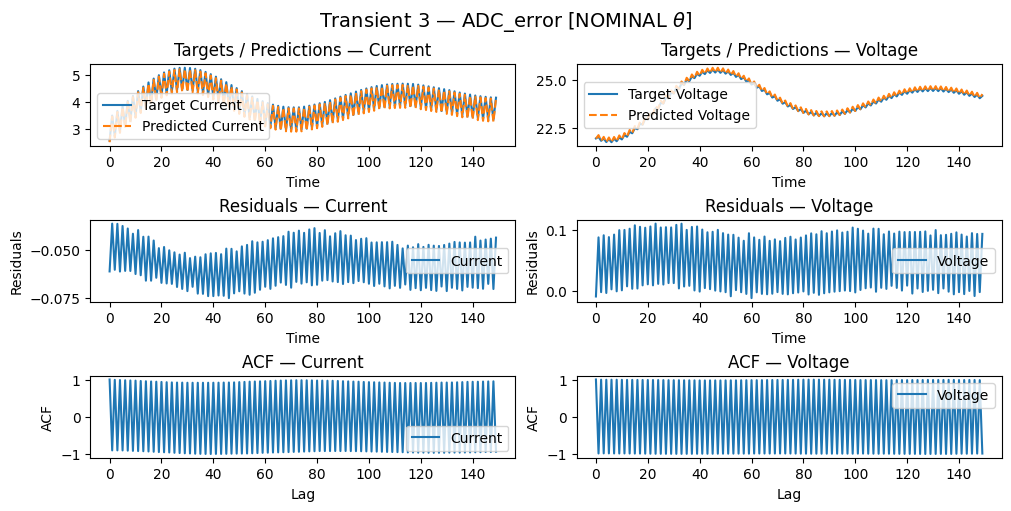

In [54]:
from pinn_buck.model.residuals import basic_residual
from pinn_buck.model.loss_function_archive import loss_whitened
from pinn_buck.constants import ParameterConstants, MeasurementGroupArchive


io = LoaderH5(db_dir, h5filename)

acfs = {}

group_number = 1
group_name = MeasurementGroupArchive.SHUAI_ORIGINAL[group_number]

print(f"Loading group {group_number}: {group_name}")
io.load(group_name)

print(f"\n{'-'*50}")

# Train the model on the noisy measurement
X = torch.tensor(io.M.data, device=device)

model = BuckParamEstimator(param_init=NOMINAL).to(device)
predictions = model(X)
targets = model.targets(X)
residuals = basic_residual(predictions, model.targets(X))
res_diag = ResidualDiagnosticsGaussian(residuals)
acf = res_diag.acf()

vif = res_diag.quadloss_vif_from_residuals()

# iterate over the three vif values
print(f"The VIF values are:", end="")
for vif_i in vif:
    print(f"{vif_i:.2f}", end=" ")

res_diag.plot_acf(acf, targets, predictions, residuals, group_label=group_name+" [NOMINAL $\\theta$]", nlags=150);

The VIF values are:1.60 1.47 1.47 

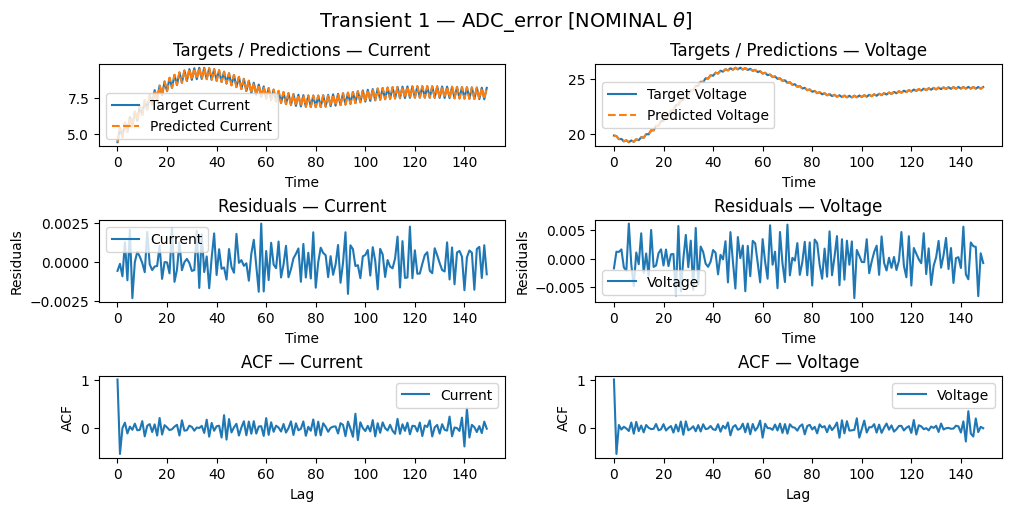

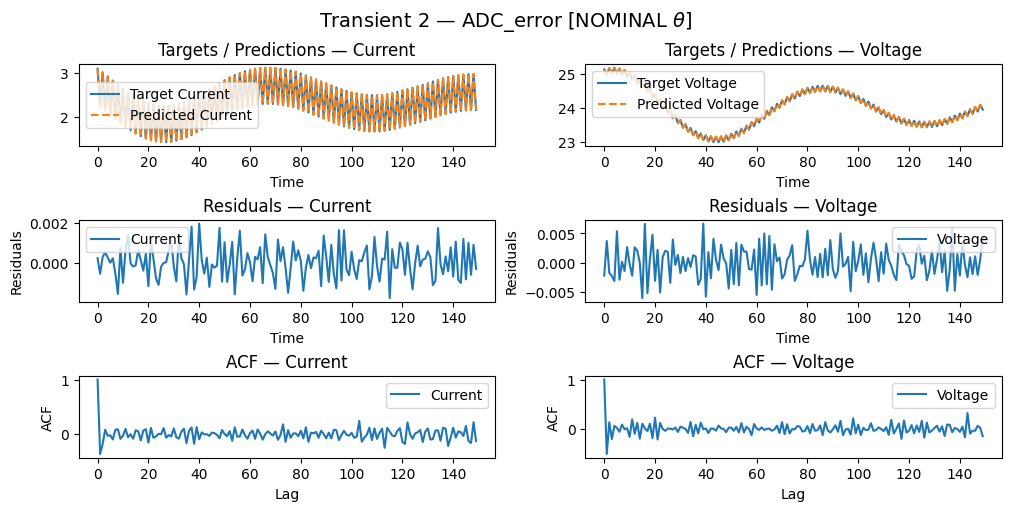

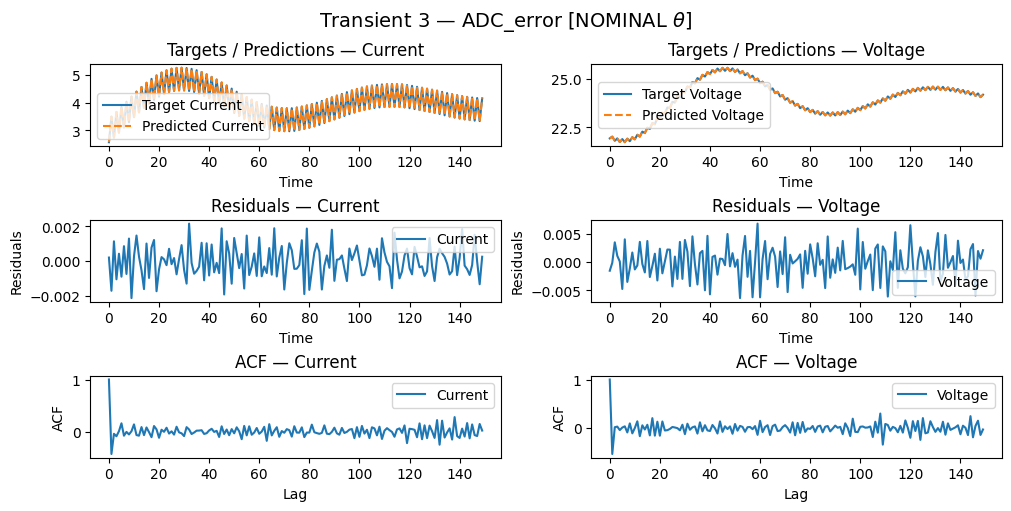

In [55]:
from pinn_buck.config import Parameters
from pinn_buck.model.trainer import TrainingHistory

out_dir = Path.cwd().parent / "RESULTS" / "LIKELIHOODS" / "FWD"

histories = {}
best_params_dict = {}
for name in MeasurementGroupArchive.SHUAI_ORIGINAL.values():
    path_name = out_dir / f"history_{name}.csv"
    if path_name.exists():
        history: TrainingHistory = TrainingHistory.from_csv(path_name)
        histories[name] = history
        best_params_dict[name] = history.get_best_parameters()


model = BuckParamEstimator(param_init=best_params_dict[group_name]).to(device)
predictions = model(X)
targets = model.targets(X)
residuals = basic_residual(predictions, model.targets(X))
res_diag = ResidualDiagnosticsGaussian(residuals)
acf = res_diag.acf()

vif = res_diag.quadloss_vif_from_residuals()

# iterate over the three vif values
print(f"The VIF values are:", end="")
for vif_i in vif:
    print(f"{vif_i:.2f}", end=" ")


res_diag.plot_acf(
    acf, targets, predictions, residuals, group_label=group_name + " [NOMINAL $\\theta$]", nlags=150
);

The VIF values are:1.60 1.47 1.48 

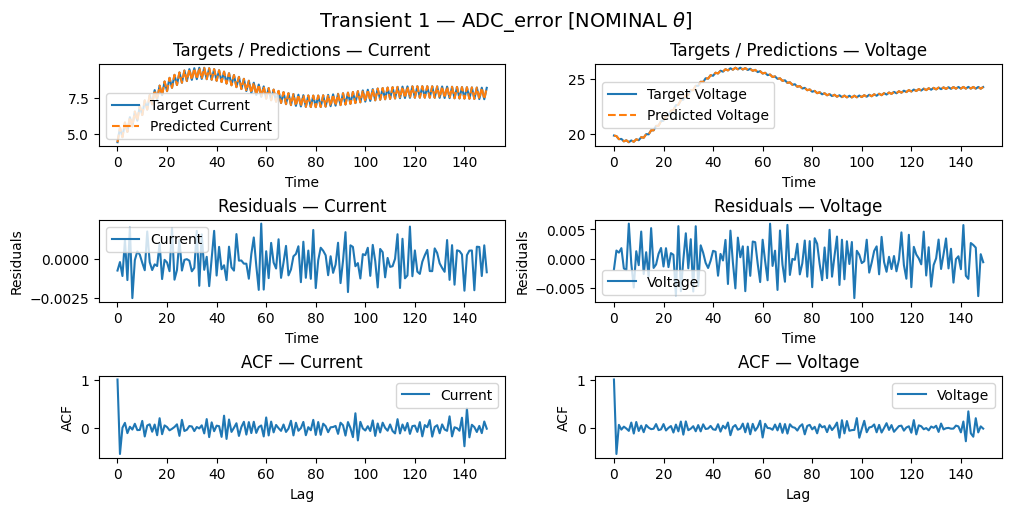

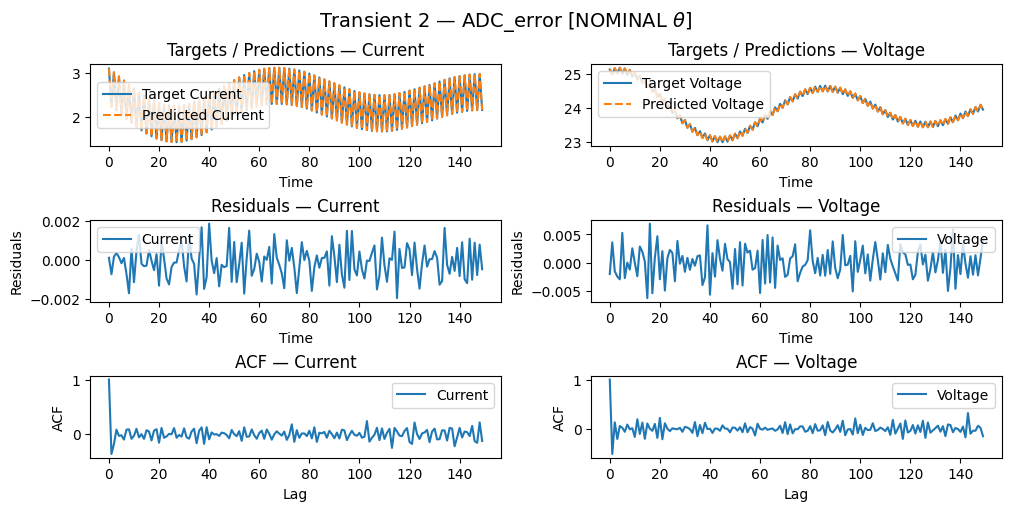

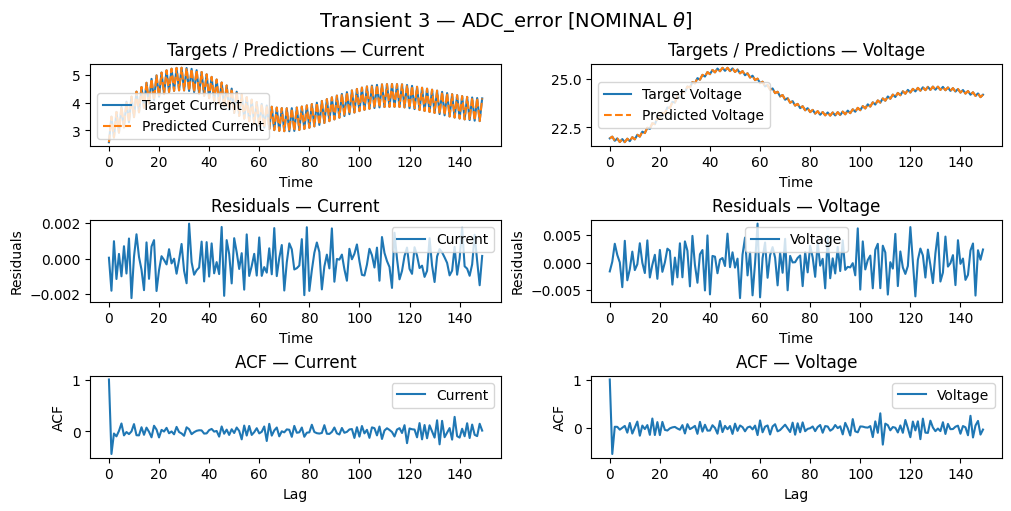

In [56]:
model = BuckParamEstimator(param_init=TRUE_PARAMS).to(device)
predictions = model(X)
targets = model.targets(X)
residuals = basic_residual(predictions, model.targets(X))
res_diag = ResidualDiagnosticsGaussian(residuals)
acf = res_diag.acf()

vif = res_diag.quadloss_vif_from_residuals()

# iterate over the three vif values
print(f"The VIF values are:", end="")
for vif_i in vif:
    print(f"{vif_i:.2f}", end=" ")


res_diag.plot_acf(
    acf, targets, predictions, residuals, group_label=group_name + " [NOMINAL $\\theta$]", nlags=150
);